# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [20]:
from sklearn.base import ClusterMixin
import random
from collections import Counter

class KMeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        if random_state != None:
            np.random.seed(random_state)
        else:
            np.random.seed(10)
            
    def initialize_centroids(self, X):
        """
        Процедура инициализации начальных значений центроидов
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        #epsilon
        self.eps = 0.0001
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(X.shape[0])
        
        # Массив с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        # Делаем случайные центры (k-means)
        if self.init == 'random':
            idxs = random.sample(xrange(X.shape[0]), self.k)
            self.centroids = np.array([X[idxs[i],] for i in xrange(self.k)])
                
        # k-means++
        elif self.init == 'k-means':            
            self.centroids[0] = X[np.random.randint(0, self.k),]
            
            for centroids_num in xrange(1, self.k):
                prob =[]
                cum_prob = []
                for point in xrange(X.shape[0]):
                    dist = [((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(centroids_num)]
                    
                    prob += [min(dist)]
                    cum_prob += [np.array(prob).sum()]
                    
                all_prob = np.array(prob).sum()
                all_prob *= np.random.random_sample()
                
                for prob in cum_prob:
                    if prob > all_prob:
                        self.centroids[centroids_num] = X[cum_prob.index(prob),]
                        break
            

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        self.initialize_centroids(X)
        
        # k-means
        iter_num = 0
        while iter_num < self.max_iter:
            fixed_number = 0
            
            # Делим все на кластеры
            for point in xrange(X.shape[0]):
                dist = [np.sqrt((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(self.k)]
                self.labels[point] = np.argmin(dist)
        
            # Пересчитываем центры
            cnt = Counter(self.labels)
    
            for clast in xrange(self.k):
                sum_coord = np.zeros(X.shape[1])
                
                for point in xrange(X.shape[0]):
                    if (self.labels[point] == clast):
                        sum_coord += X[point, ]

                new_centroid = sum_coord / [cnt[clast] for i in xrange(X.shape[1])]
                
                # Насколько сдвинется центроид
                if (np.abs(new_centroid - self.centroids[clast]) < self.eps).all():
                    fixed_number += 1 
                
                self.centroids[clast] = new_centroid
        
            iter_num += 1
            if fixed_number == self.k:
                # print "Iterations number: {}".format(iter_num)        
                return self
            
        # print "Iterations number: {}".format(iter_num)        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.labels, self.centroids

class MiniBatchKMeans(KMeans):
    def __init__(self, k=2, batch_size=50, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :batch_size - количество
        """
        super(MiniBatchKMeans, self).__init__(k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    
    
    def fit(self, X, y=None):
        """
        Процедура обучения mini-batch k-means 
        """
        
        self.initialize_centroids(X)
        iter_num = 0
        
        if self.batch_size > X.shape[0]:
            self.batch_size = X.shape[0] // 10

        counts_per_centroid = np.zeros(self.k)
        batch_labels = np.empty(self.batch_size, dtype=int)
        new_centroids = np.empty((self.k, X.shape[1]))
        
        for iter_num in xrange(self.max_iter):
            
            # Выделяем новую выборку
            idxs = random.sample(xrange(X.shape[0]), self.batch_size)
            batches = np.array([X[idxs[i],] for i in xrange(self.batch_size)])
            # new_centroids = np.empty((self.k, X.shape[1]))
            fixed_number = 0
        
            # Считаем ближайший кластер для каждой точки в выборке
            for point in xrange(self.batch_size):
                dist = [np.sqrt((self.centroids[i] - batches[point,]) ** 2).sum() for i in xrange(self.k)]
                batch_labels[point] = np.argmin(dist)
            
            for point in xrange(self.batch_size):
            # Увеличиваем число точек в кластере
                curr_clast = int(batch_labels[point])
                counts_per_centroid[curr_clast] += 1
                
                # Шаг градиента
                theta = 1 / counts_per_centroid[curr_clast]
                new_centroid = (1 - theta) * self.centroids[curr_clast] + theta * batches[point]
                
                self.centroids[curr_clast] = new_centroid
                
            # Считаем метки
            for point in xrange(X.shape[0]):
                dist = [np.sqrt((self.centroids[i] - X[point, ]) ** 2).sum() for i in xrange(self.k)]
                self.labels[point] = np.argmin(dist)
            
        # print "Iterations number: {}".format(iter_num + 1)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [21]:
from sklearn.datasets import make_blobs

In [22]:
X, y = make_blobs(n_samples=3000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

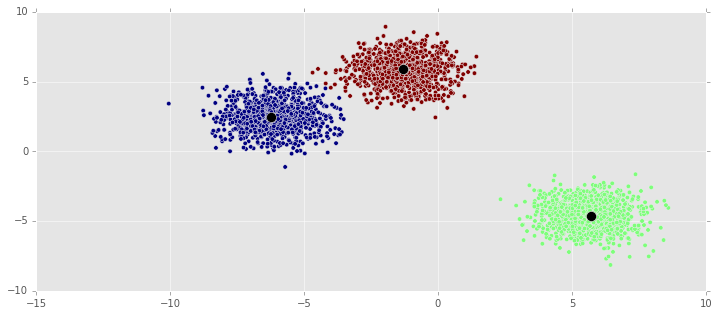

In [23]:
model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, batch_size=100, max_iter=3)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

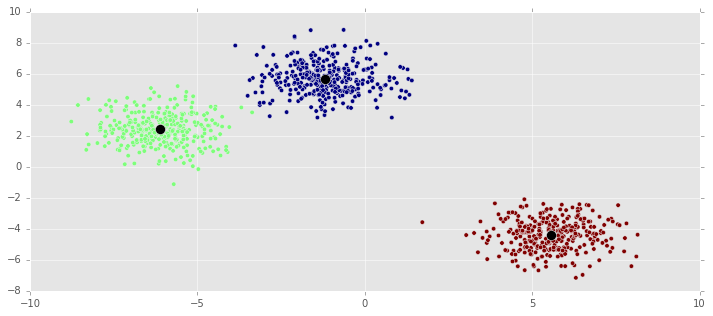

In [105]:
## Работоспособность KMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='random', random_state=123)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены.
# Вероятно, это происходит, когда две случайно выбранные начальные координаты центров попадают в один кластер.

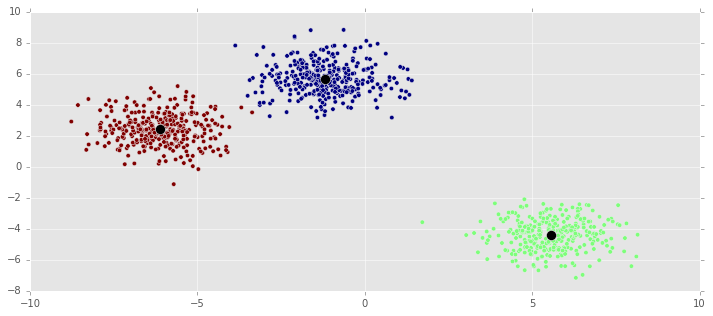

In [106]:
## Работоспособность KMeans++

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = KMeans(k=3,  init='k-means')
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

# Почти всегда разбивает правильно на 3 кластера, 
# но иногда один из них разбит пополам, а два других объединены (вроде бы реже, чем при обычном k-means)
# Происходит это потому что выбор нового центроида тоже происходит случайно.

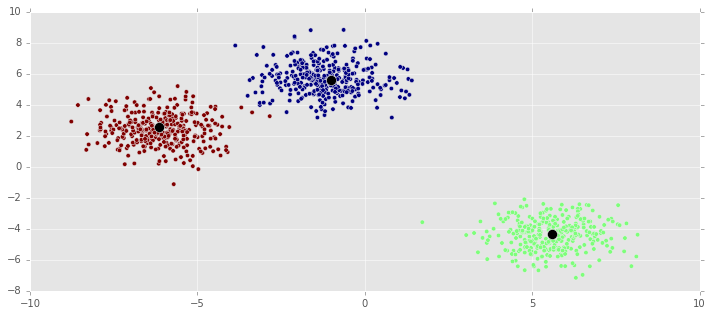

In [107]:
## Работоспособность KMeans с MiniBatchKMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = MiniBatchKMeans(k=3,  init='random', random_state=123, batch_size=50, max_iter=10)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

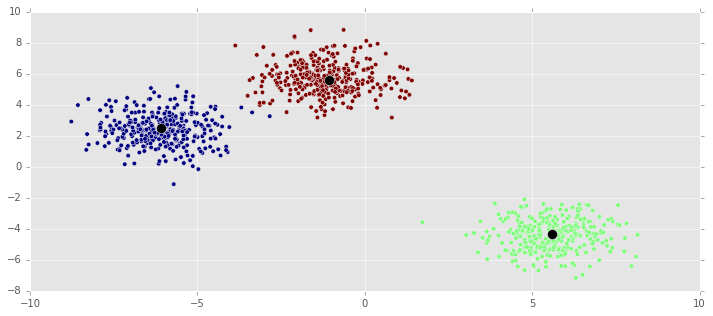

In [108]:
## Работоспособность KMeans++ с MiniBatchKMeans

X, y = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, batch_size=50, max_iter=5)
model.fit(X)
y, centers = model.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black')
plt.show()

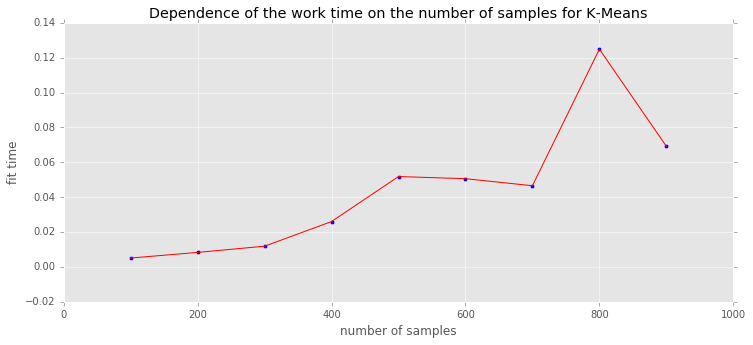

In [117]:
## Время выполнения алгоритма KMeans

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = KMeans(k=3,  init='random', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for K-Means')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# Очень странно и иногда довольно рандомно    

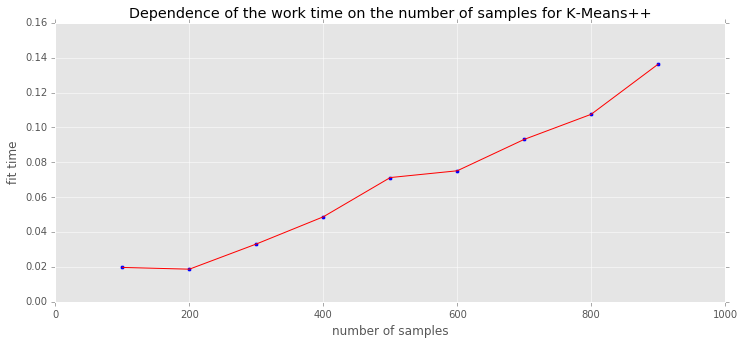

In [125]:
## Время выполнения алгоритма KMeans++

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = KMeans(k=3,  init='k-means', random_state=123)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for K-Means++')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# Уже намного стабильнее, но в большинстве случаев дольше

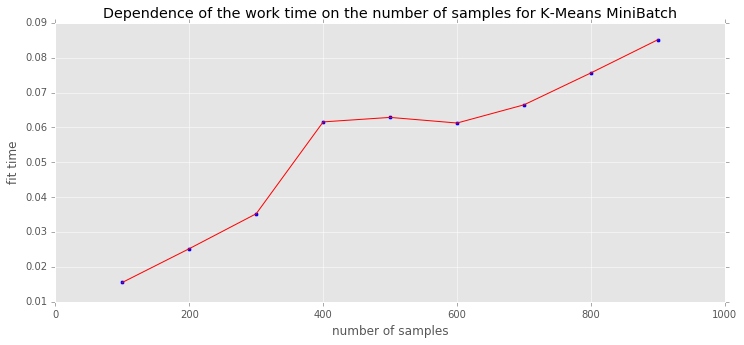

In [126]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = MiniBatchKMeans(k=3,  init='random', random_state=123, max_iter=5)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for K-Means MiniBatch')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# Немного быстрее

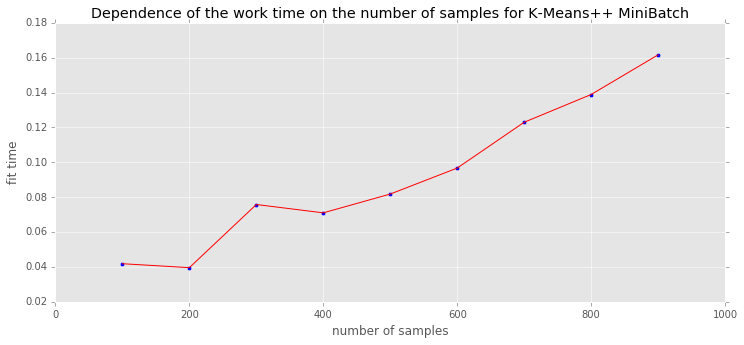

In [127]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

times = []
for num_samples in xrange(100, 1000, 100):
    X, y = make_blobs(n_samples=num_samples, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    
    model = MiniBatchKMeans(k=3,  init='k-means', random_state=123, max_iter=5)
    time = %timeit -o -q -n 1 -r 1 model.fit(X)
    times += [time.best]
    
steps = [t for t in xrange(100, 1000, 100)]

plt.plot(steps, times, c='red')
plt.scatter(steps, times, c='blue')
plt.title('Dependence of the work time on the number of samples for K-Means++ MiniBatch')
plt.xlabel('number of samples')
plt.ylabel('fit time')

plt.show()

# На небольших объемах быстрее обычного K-Means++, а дальше медленнее

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [58]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()
df_sns.shape[0]

30000

Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [59]:
## KMeans

In [60]:
## KMeans++

In [61]:
## KMeans с MiniBatchKMeans

In [62]:
## KMeans++ с MiniBatchKMeans

In [63]:
## Вывод